# Image Processing and Computational Photography

------

## Seminar: From Pair-Based to Unpaired Image Enhancement 

#### Instructors: Georgy Perevozchikov (PhD), Prof. Dr. Radu Timofte

<br>
<br>

# Image Enhancement

## Content
- Pair-Based Optimization
  - Classical Approaches
    - Leniar regression
    - Polynomial regression
    - Root Polynomial regression
    - KANs
- Supervised Training
  - DPED
  - MW-ISP Net
  - cmKAN
- Unsupervised Training
  - Cycle GAN
  - WESPE
  - UVCGAN v2 / Rawformer
  - Schroedinger Bridge and Optimal Transport

# Metrics

Quality assessment metrics for reconstructed images often include Peak Signal-to-Noise Ratio (PSNR) and Structural Similarity Index Measure (SSIM).

#### PSNR

**PSNR** measures the fidelity of the reconstructed image in terms of pixel-wise differences. It is calculated as:

$$PSNR = 10 \log_{10} \left( \frac{MAX^2}{MSE} \right)$$

where $MAX$ is the maximum possible pixel value (e.g., 255 for 8-bit images) and $MSE$ is the Mean Squared Error between the original and reconstructed images. Higher PSNR values indicate better reconstruction quality.

#### SSIM

**SSIM** evaluates the structural similarity between the original and reconstructed images, considering aspects like luminance, contrast, and structure. It is calculated as:

$$SSIM = \frac{(2 \mu_x \mu_y + C_1)(2 \sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}$$

where $\mu_x$ and $\mu_y$ are the means of the original and reconstructed images, respectively $\sigma_x^2$ and $\sigma_y^2$ are their variances, $\sigma_{xy}$ is their covariance, and $C_1$ and $C_2$ are small constants to prevent division by zero. SSIM values range from 0 to 1, with 1 indicating perfect similarity.

In essence, PSNR focuses on pixel-level intensity differences, while SSIM emphasizes the preservation of structural information. Both metrics are commonly used together to provide a comprehensive assessment of reconstruction quality.

#### Delta E

**Delta E (ΔE)** is a metric used to quantify the color difference between two colors.  It aims to represent the perceived difference by the human eye, going beyond simple mathematical differences in color component values.  A lower ΔE value indicates a smaller perceived color difference.  Several different ΔE formulas exist, each with its own strengths and weaknesses, designed for specific applications. A common one is CIE76:


$$ΔE76 = sqrt((L*1 - L*2)^2 + (a*1 - a*2)^2 + (b*1 - b*2)^2)$$


Where $L*$, $a*$, and $b*$ represent the coordinates of the two colors in the CIELAB color space.

Interpretation:
- ΔE of 0-1: No perceived difference.   
- ΔE of 1-2: A very small difference, may be noticeable under close inspection.   
- ΔE of 2-3: A difference that may be noticeable at a glance.   
- Higher ΔE values: Increasingly obvious color differences.



These metrics are available in the `torchmetrics` package ([https://lightning.ai/docs/torchmetrics/stable/](https://lightning.ai/docs/torchmetrics/stable/)).


# Pair-Based Optimization

![Pair-Based](https://cclaassen3.github.io/computer-vision-local-feature-matching/images/mountrushmore99percent.jpg)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.linear_model import LinearRegression

from networks.utils.utils import RootPolynomialFeatures, RobustScalableRationalFeatures
from sklearn.preprocessing import PolynomialFeatures


def plot_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))

    for i, (image, title) in enumerate(zip(images, titles)):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(title)

        # Get minimum and maximum values of image
        image_min = np.min(image)
        image_max = np.max(image)

        # Add min and max values to plot
        text = f"min={image_min:.2f}, max={image_max:.2f}"
        axes[i].text(0.5, -0.1, text, transform=axes[i].transAxes,
                     fontsize=12, ha='center')

    plt.show()

In [2]:
from networks.color_transfer.ml.metrics import DeltaE, PSNR, SSIM
from torchvision.transforms.v2 import (
    Compose,
    ToImage,
    ToDtype,
)
import torch


def psnr(img1, img2):
    transform = Compose([
            ToImage(),
            ToDtype(dtype=torch.float32, scale=True),
    ])
    psnr = PSNR()
    img1 = transform(img1).unsqueeze(0)
    img2 = transform(img2).unsqueeze(0)
    return psnr(img1, img2).cpu().numpy()


def ssim(img1, img2):
    transform = Compose([
            ToImage(),
            ToDtype(dtype=torch.float32, scale=True),
    ])
    ssim = SSIM()
    img1 = transform(img1).unsqueeze(0)
    img2 = transform(img2).unsqueeze(0)
    return ssim(img1, img2).cpu().numpy()


def d_e2000(img1, img2):
    transform = Compose([
            ToImage(),
            ToDtype(dtype=torch.float32, scale=True),
    ])
    de = DeltaE()
    img1 = transform(img1).unsqueeze(0)
    img2 = transform(img2).unsqueeze(0)
    return de(img1, img2).cpu().numpy()

(1048576, 3)


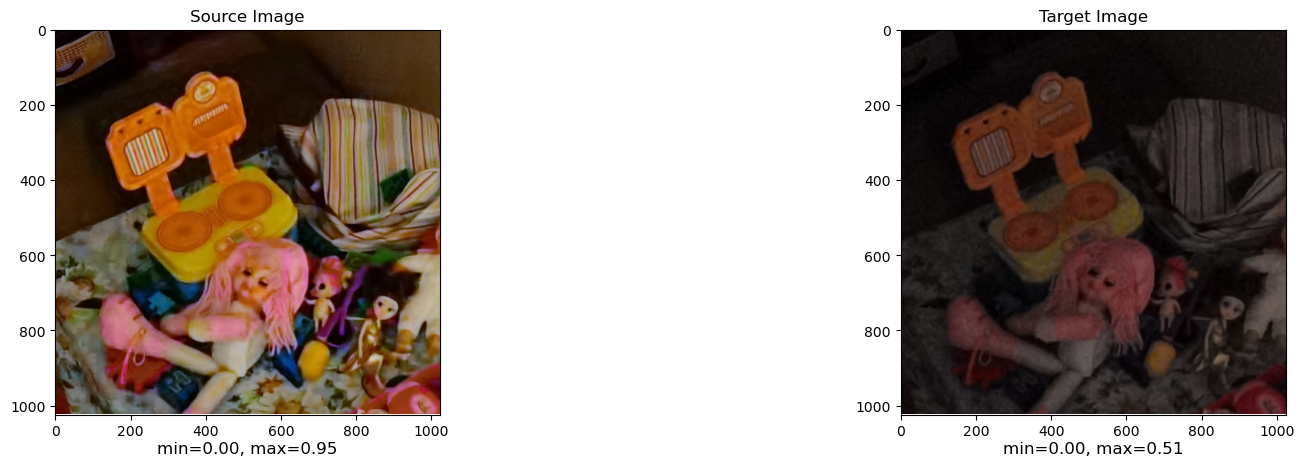

In [3]:
source_image = cv2.imread('datasets/samara/src_P40_S0888.jpg')
target_image = cv2.imread('datasets/samara/tgt_P40_S0888.jpg')
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
source_image = source_image / 255.0
target_image = target_image / 255.0

source_features = source_image.reshape(-1, 3)
target_features = target_image.reshape(-1, 3)

print(source_features.shape)

plot_images([source_image, target_image], ['Source Image', 'Target Image'])

In [4]:
psnr_value = psnr(source_image, target_image)
ssim_value = ssim(source_image, target_image)
d_e2000_value = d_e2000(source_image, target_image)

print(f'PSNR: {psnr_value}')
print(f'SSIM: {ssim_value}')
print(f'Delta E2000: {d_e2000_value}')

PSNR: 7.385390758514404
SSIM: 0.554080069065094
Delta E2000: 21.316457748413086


### Linear Regression

$y = a_0 + a_1x$

In [5]:
linear_regres = LinearRegression(fit_intercept=False)
linear_regres = linear_regres.fit(source_features, target_features)
linear_regres.coef_

array([[ 0.43960057, -0.00183619, -0.03298267],
       [ 0.05968315,  0.33665929, -0.02943417],
       [ 0.04137272,  0.21674125,  0.11826957]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 25.01906394958496
SSIM: 0.81254643201828
Delta E2000: 3.741842746734619


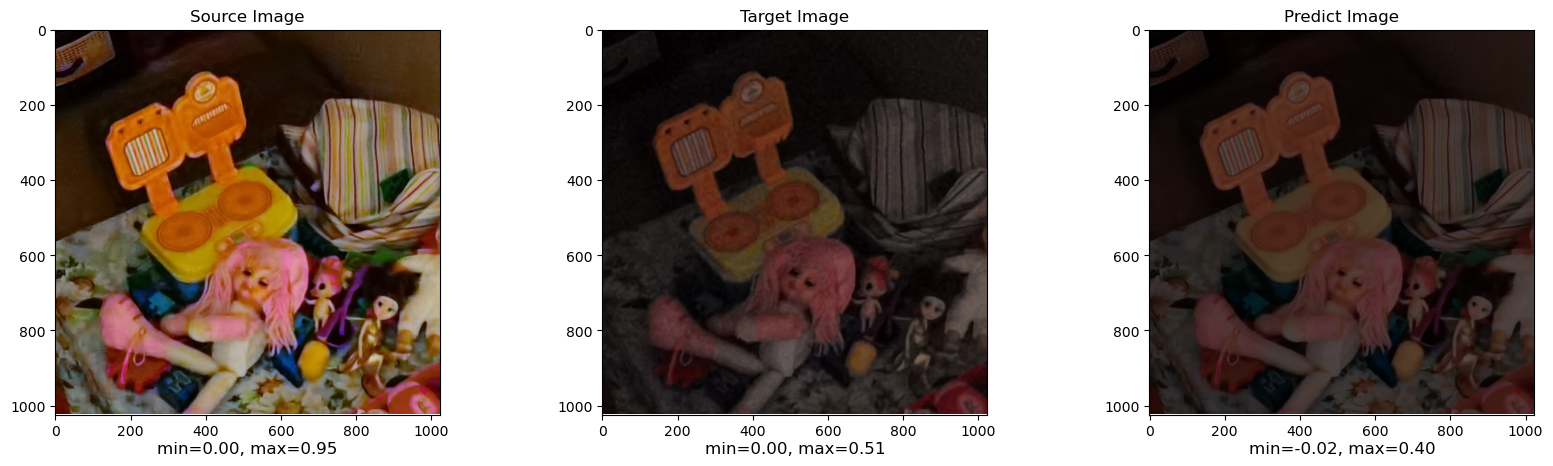

In [6]:
predict_image = linear_regres.predict(source_image.reshape(-1, 3)).reshape(1024, 1024, 3)

psnr_value = psnr(predict_image, target_image)
ssim_value = ssim(predict_image, target_image)
d_e2000_value = d_e2000(predict_image, target_image)

print(f'PSNR: {psnr_value}')
print(f'SSIM: {ssim_value}')
print(f'Delta E2000: {d_e2000_value}')

plot_images([source_image, target_image, predict_image], ['Source Image', 'Target Image', 'Predict Image'])

#### Polynomial Features

$y = a_0 + a_1*x + a_2*x^2 + a_3*x^3 + ... + a_n*x^n$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 27.04775619506836
SSIM: 0.8119794130325317
Delta E2000: 2.5494697093963623


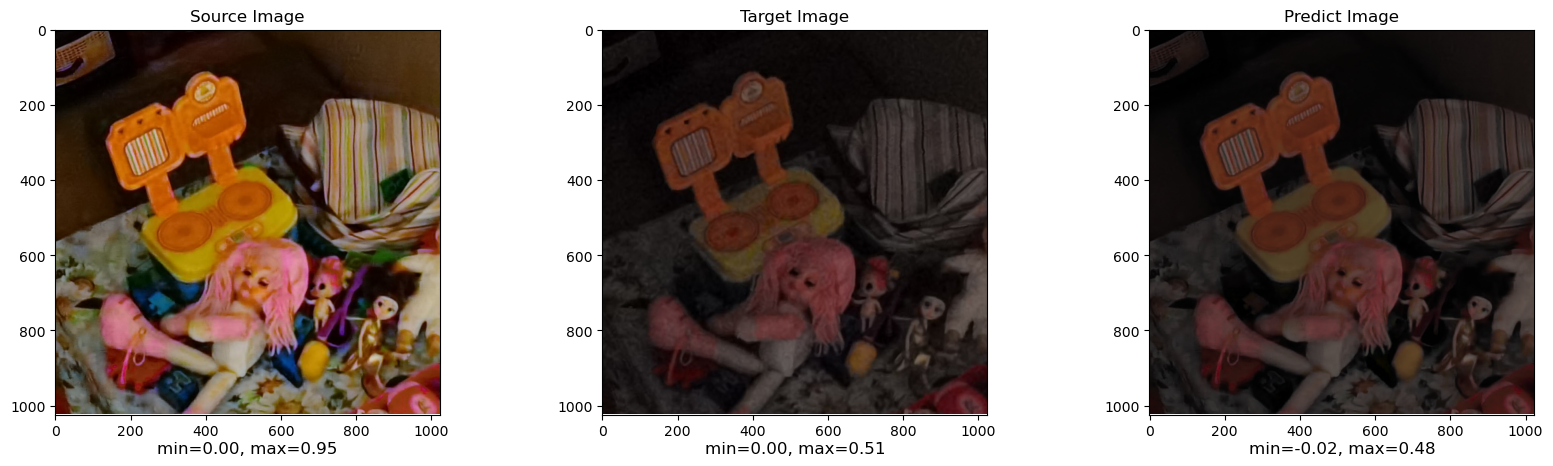

In [7]:
poly_transform = PolynomialFeatures(2, include_bias=False)
source_features_poly = poly_transform.fit_transform(source_features)
linear_regres = LinearRegression(fit_intercept=False)
linear_regres = linear_regres.fit(source_features_poly, target_features)

predict_image = linear_regres.predict(
    poly_transform.transform(source_image.reshape(-1, 3))
).reshape(1024, 1024, 3)

psnr_value = psnr(predict_image, target_image)
ssim_value = ssim(predict_image, target_image)
d_e2000_value = d_e2000(predict_image, target_image)

print(f'PSNR: {psnr_value}')
print(f'SSIM: {ssim_value}')
print(f'Delta E2000: {d_e2000_value}')

plot_images([source_image, target_image, predict_image], ['Source Image', 'Target Image', 'Predict Image'])

#### Root-Polynomial and Scalable Rational Features

- Root-Polynomial: $y = a_0 + a_1*x + a_2*x^{1/2} + a_3*x^{1/3} + ... + a_n*x^{1/n}$
- Scalable Rational: $y = a_0 + a_1*x + a_2/(x + e) + a_3/(x^2 + e) + ... + a_n/(x^{n-1} + e)$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 26.89790916442871
SSIM: 0.8324159383773804
Delta E2000: 2.7209534645080566


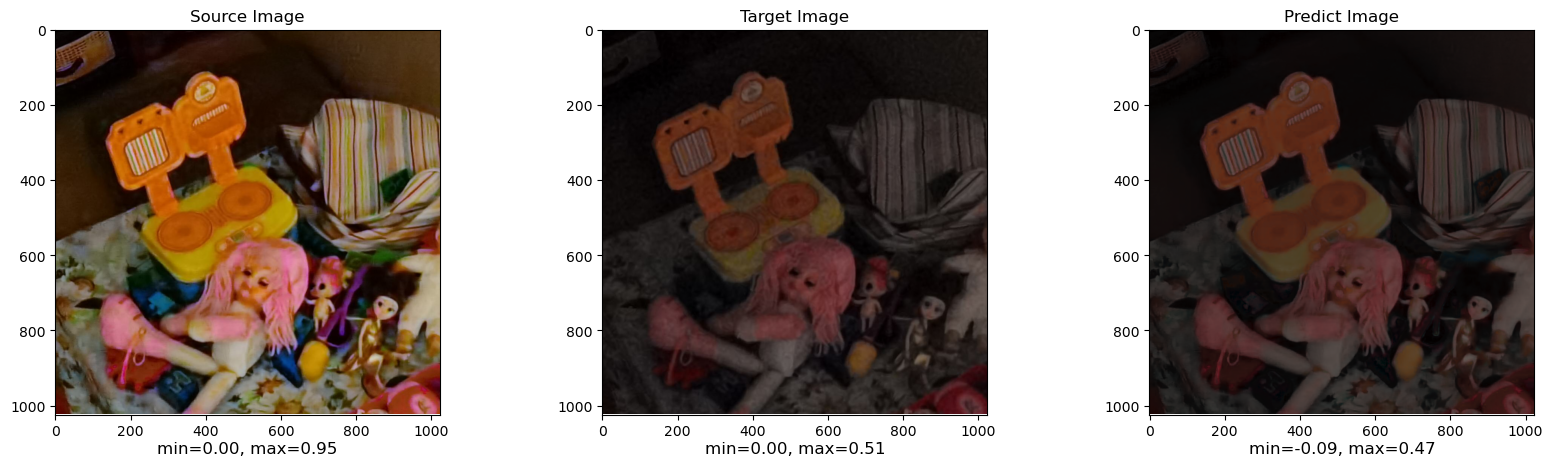

In [8]:
#root_transform = RootPolynomialFeatures(7)
root_transform = RobustScalableRationalFeatures(5, 0.1)
source_features_root = root_transform.fit_transform(source_features)
linear_regres = LinearRegression(fit_intercept=False)
linear_regres = linear_regres.fit(source_features_root, target_features)

predict_image = linear_regres.predict(
    root_transform.transform(source_image.reshape(-1, 3))
).reshape(1024, 1024, 3)

psnr_value = psnr(predict_image, target_image)
ssim_value = ssim(predict_image, target_image)
d_e2000_value = d_e2000(predict_image, target_image)

print(f'PSNR: {psnr_value}')
print(f'SSIM: {ssim_value}')
print(f'Delta E2000: {d_e2000_value}')

plot_images([source_image, target_image, predict_image], ['Source Image', 'Target Image', 'Predict Image'])

### MLP

In [9]:
from networks.color_transfer.ml.models import SimpleMlpModel
from networks.color_transfer.ml.pipelines import DefaultPipeline
from networks.color_transfer.ml.datasets import ImgDataModule
import lightning as L

model = SimpleMlpModel(
    in_dims=[3],
    out_dims=[3],
)

pipeline = DefaultPipeline(
    model=model,
)

dm = ImgDataModule(
    x_img=source_image,
    y_img=target_image,
)

trainer = L.Trainer(
    accelerator='gpu',
    max_epochs=40,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [77]:
trainer.fit(
    model=pipeline,
    datamodule=dm,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                             | Params
-----------------------------------------------------------------
0 | model       | SimpleMlpModel                   | 13    
1 | mae_loss    | L1Loss                           | 0     
2 | de_metric   | DeltaE                           | 0     
3 | ssim_metric | StructuralSimilarityIndexMeasure | 0     
4 | psnr_metric | PeakSignalNoiseRatio             | 0     
-----------------------------------------------------------------
13        Trainable params
0         Non-trainable params
13        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


PSNR: 25.115440368652344
SSIM: 0.815536618232727
Delta E2000: 3.6637980937957764


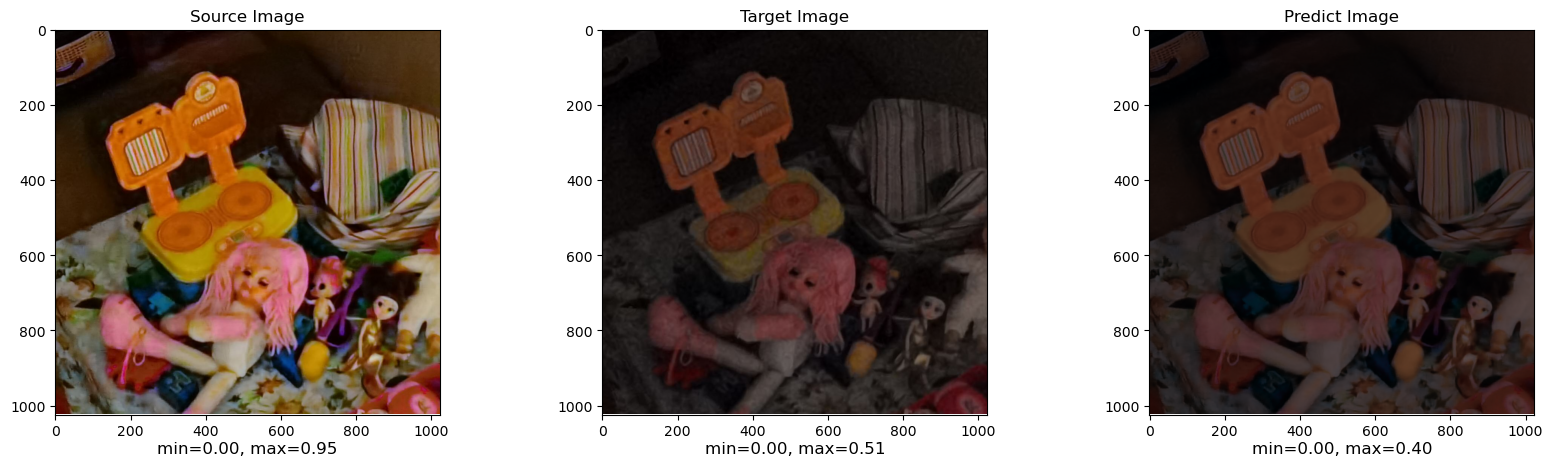

In [78]:
dm.setup('test')

x = dm.test_dataset.__getitem__(0)[0].unsqueeze(0)
mlp_img = pipeline.eval()(x).detach()

x = x.squeeze(0).permute(1, 2, 0).numpy()
mlp_img = mlp_img.squeeze(0).permute(1, 2, 0).numpy()

psnr_value = psnr(mlp_img, target_image)
ssim_value = ssim(mlp_img, target_image)
d_e2000_value = d_e2000(mlp_img, target_image)

print(f'PSNR: {psnr_value}')
print(f'SSIM: {ssim_value}')
print(f'Delta E2000: {d_e2000_value}')

plot_images([source_image, target_image, mlp_img], ['Source Image', 'Target Image', 'Predict Image'])

### KAN

![KAN](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fc02b09e2-34dd-4964-b006-b279cce49a11_800x491.jpeg)

In [10]:
from networks.color_transfer.ml.models import SimpleKanModel
from networks.color_transfer.ml.pipelines import DefaultPipeline
from networks.color_transfer.ml.datasets import ImgDataModule
import lightning as L

model = SimpleKanModel(
    in_dims=[3, 7],
    out_dims=[7, 3],
    grid_size=5,
    spline_order=3,
    residual_std=0.1,
    grid_range=[0.0, 1.0],
)

pipeline = DefaultPipeline(
    model=model,
)

dm = ImgDataModule(
    x_img=source_image,
    y_img=target_image,
)

trainer = L.Trainer(
    accelerator='gpu',
    max_epochs=40,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [86]:
trainer.fit(
    model=pipeline,
    datamodule=dm,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                             | Params
-----------------------------------------------------------------
0 | model       | SimpleKanModel                   | 504   
1 | mae_loss    | L1Loss                           | 0     
2 | de_metric   | DeltaE                           | 0     
3 | ssim_metric | StructuralSimilarityIndexMeasure | 0     
4 | psnr_metric | PeakSignalNoiseRatio             | 0     
-----------------------------------------------------------------
420       Trainable params
84        Non-trainable params
504       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


PSNR: 28.206331253051758
SSIM: 0.8301130533218384
Delta E2000: 2.254049777984619


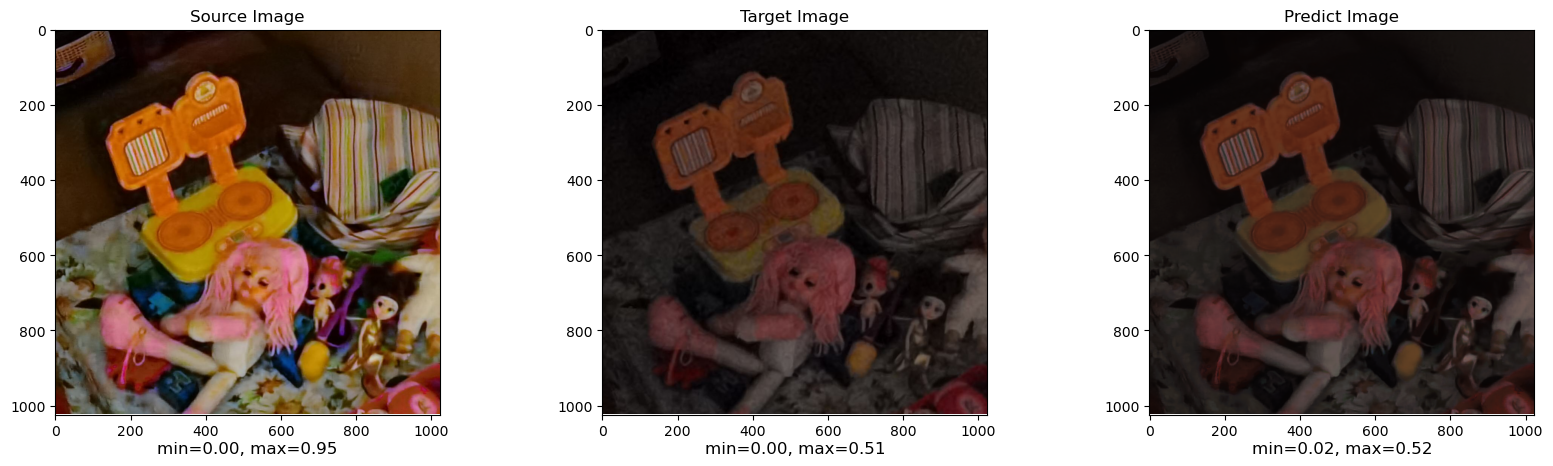

In [87]:
dm.setup('test')

x = dm.test_dataset.__getitem__(0)[0].unsqueeze(0)
kan_img = pipeline.eval()(x).detach()

x = x.squeeze(0).permute(1, 2, 0).numpy()
kan_img = kan_img.squeeze(0).permute(1, 2, 0).numpy()

psnr_value = psnr(kan_img, target_image)
ssim_value = ssim(kan_img, target_image)
d_e2000_value = d_e2000(kan_img, target_image)

print(f'PSNR: {psnr_value}')
print(f'SSIM: {ssim_value}')
print(f'Delta E2000: {d_e2000_value}')

plot_images([source_image, target_image, kan_img], ['Source Image', 'Target Image', 'Predict Image'])

# Supervised Training
### DPED 

- https://people.ee.ethz.ch/~ihnatova/

In [11]:
import os
os.chdir('networks/dped/')

In [14]:
import numpy as np
import tensorflow as tf
import os
import scipy.misc
from easydict import EasyDict as edict
from DPED import *
from utils import *
from ops import *

%reload_ext autoreload
%autoreload 2

config = edict()
# training parameters
config.batch_size = 50
config.patch_size = 100
config.mode = "RGB" #YCbCr
config.channels = 3
config.content_layer = 'relu5_4'
config.learning_rate = 1e-4
config.augmentation = True #data augmentation (flip, rotation)

# weights for loss
config.w_color = 1.2 # gaussian blur + mse (originally 0.1)
config.w_texture = 1 # gan (originally 0.4)
config.w_content = 2 # vgg19 (originally 1)
config.w_tv = 1/400 # total variation (originally 400)

# directories
config.dataset_name = "iphone"
config.train_path_phone = os.path.join("./dped",str(config.dataset_name),"training_data",str(config.dataset_name),"*.jpg")
config.train_path_dslr = os.path.join("./dped",str(config.dataset_name),"training_data/canon/*.jpg")
config.test_path_phone_patch = os.path.join("./dped",str(config.dataset_name),"test_data/patches",str(config.dataset_name),"*.jpg")
config.test_path_dslr_patch = os.path.join("./dped",str(config.dataset_name),"test_data/patches/canon/*.jpg")
config.test_path_phone_image = os.path.join("./dped/sample_images/original_images",str(config.dataset_name),"*.jpg")
config.test_path_dslr_image = os.path.join("./dped/sample_images/original_images/canon/*.jpg")
config.sample_dir = "samples"
config.checkpoint_dir = "checkpoint"
config.vgg_dir = "./vgg_pretrained/imagenet-vgg-verydeep-19.mat"
config.log_dir = "logs"

if not os.path.exists(config.checkpoint_dir):
    os.makedirs(config.checkpoint_dir)
if not os.path.exists(config.sample_dir):
    os.makedirs(config.sample_dir)
if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)

In [15]:
# load dataset
dataset_phone, dataset_dslr = load_dataset(config)

Dataset: iphone, 0 image pairs
0 image pairs loaded! setting took: 0.0000s


In [17]:
# build DPED model
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()
model = DPED(sess, config, dataset_phone, dataset_dslr)

Instructions for updating:
non-resource variables are not supported in the long term


W0000 00:00:1738598944.678640 1839384 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


AttributeError: `conv2d` is not available with Keras 3.

In [ ]:
model.test_generator(100, 14, load = True)

In [ ]:
# pretrain discriminator with (phone, dslr) pairs
model.pretrain_discriminator(load = False, epoch = 1)
# train generator & discriminator together
model.train(load = True, epoch = 1)
model.save()

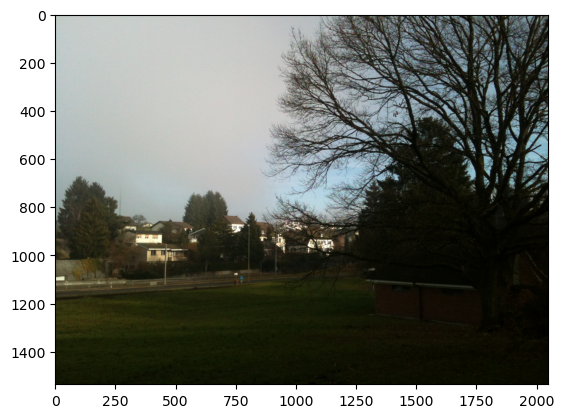

In [18]:
import matplotlib.pyplot as plt

img = plt.imread('./samples/iphone/image/phone_0.png')
plt.imshow(img)

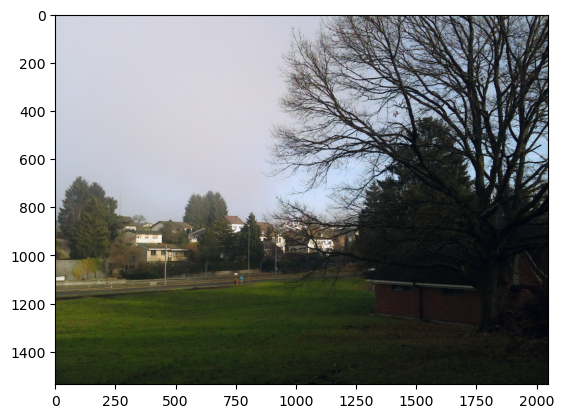

In [19]:
img = plt.imread('./samples/iphone/image/enhanced_0.png')
plt.imshow(img)

### MW-ISP Net

![mw_isp](figures/mw_isp.png)

In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import Adam
import torch
import matplotlib.pyplot as plt
import random
from networks.mw_isp.core.mssim import MSSSIM
from networks.mw_isp.core.load_data import LoadTrainData
from networks.mw_isp.core.mwcnn_model import MWRCAN, Discriminator
from networks.mw_isp.core.vgg import vgg_19
from networks.mw_isp.core.utils import normalize_batch, BaseOptions
import os
from tqdm import tqdm
import math

In [2]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

0.png | 0.png
1.png | 1.png
10.png | 10.png
11.png | 11.png
12.png | 12.png
13.png | 13.png
14.png | 14.png
15.png | 15.png
16.png | 16.png
17.png | 17.png
Number of samples: 43
Number train batches: 43
Number val batches: 43


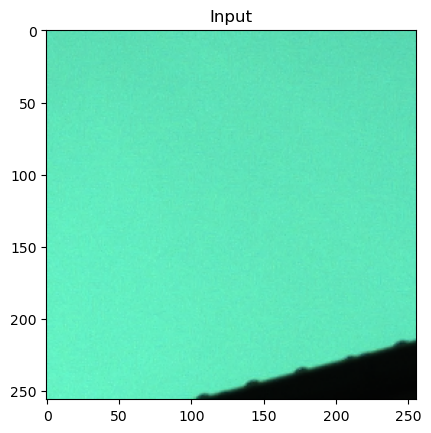

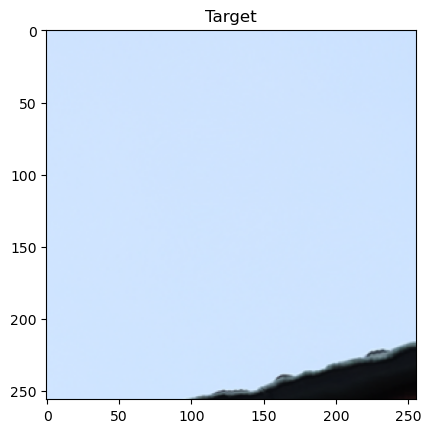

In [3]:
from networks.mw_isp.core.load_data import LoadTrainData

base_dir = "datasets/mai21/test"
train_input_dir = os.path.join(base_dir, "raw")
train_target_dir = os.path.join(base_dir, "rgb")
img_size = (126, 126)
input_channels = 3
output_channels = 3
batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png")
    ]
)


for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))
    
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
val_input_img_paths = input_img_paths
val_target_img_paths = target_img_paths

train_dataset = LoadTrainData(val_input_img_paths, val_input_img_paths)
test_dataset = LoadTrainData(val_input_img_paths, val_target_img_paths, test=True)

print("Number of samples:", len(input_img_paths))
print("Number train batches:", len(train_dataset))
print("Number val batches:", len(test_dataset))

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=12,
                              pin_memory=True, drop_last=True)
val_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=1,
                            pin_memory=True, drop_last=True)

batch = next(iter(val_loader))
batch_input, batch_target = batch
input_inage = batch_input[0].permute(1, 2, 0).numpy()
target_image = batch_target[0].permute(1, 2, 0).numpy()
plt_display(input_inage, "Input")
plt_display(target_image, "Target")

In [4]:
device = torch.device("cuda")
generator = MWRCAN().to(device)
generator = torch.nn.DataParallel(generator)
optimizer = Adam(params=generator.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [50,100,150,200], gamma=0.5)
VGG_19 = vgg_19(device)
MSE_loss = torch.nn.MSELoss()
MS_SSIM = MSSSIM()
L1_loss = torch.nn.L1Loss()
number_of_epochs = 10


for epoch in range(number_of_epochs):
    print("lr =  %.8f" % (scheduler.get_lr()[0]))
    torch.cuda.empty_cache()
    generator.to(device).train()
    n_samples = len(train_loader)
    with tqdm(total=n_samples, desc=f'Epoch {epoch + 1}/{300}', unit='batch') as pbar:
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            enhanced = generator(x)

            loss_l1 = L1_loss(enhanced, y)

            enhanced_vgg = VGG_19(normalize_batch(enhanced))
            target_vgg = VGG_19(normalize_batch(y))
            loss_content = L1_loss(enhanced_vgg, target_vgg)

            loss_ssim = MS_SSIM(enhanced, y)

            total_loss = loss_l1 + loss_content + (1 - loss_ssim) * 0.15
            
            pbar.update(1)
            pbar.set_postfix(**{
                'l1': '%.4f' % loss_l1,
                'vgg': '%.4f' % loss_content,
                'total': '%.4f' % total_loss,
            })

            total_loss.backward()
            optimizer.step()
        scheduler.step()   

    # Save the model that corresponds to the current epoch
    torch.save(generator.state_dict(), os.path.join('networks/mw_isp', "mwrcan_epoch_" + str(epoch) + ".pth"))      

    # Evaluate the model
    loss_psnr_eval = 0
    generator.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            enhanced = generator(x)
            enhanced = torch.clamp(torch.round(enhanced*255), min=0, max=255) / 255
            y = torch.clamp(torch.round(y*255), min=0, max=255) / 255
            loss_mse_temp = MSE_loss(enhanced, y).item()
            loss_psnr_eval += 20 * math.log10(1.0 / math.sqrt(loss_mse_temp))
    loss_psnr_eval = loss_psnr_eval / len(test_dataset)            
    print("Epoch %d, psnr: %.4f" % (epoch, loss_psnr_eval))

FileNotFoundError: [Errno 2] No such file or directory: 'networks/mw_isp/vgg19-dcbb9e9d.pth'

In [5]:
from torchvision.utils import make_grid

model_pth = 'src/networks/mw_isp/mwrcan.pth'
device = torch.device("cuda")
model = MWRCAN().to(device)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_pth), strict=True)
model.eval()
n = 0
max_n = 5

for x, y in val_loader:
    if n == max_n:
        break
    n += 1
    
    enhanced = model(x)
    enhanced = torch.clamp(torch.round(enhanced*255), min=0, max=255) / 255
    y = torch.clamp(torch.round(y*255), min=0, max=255) / 255
    grig = make_grid([x[0].cpu(), enhanced[0].cpu(), y[0].cpu()], nrow=3)
    grig = grig.permute(1, 2, 0).cpu().detach().numpy()
    plt_display(grig, "Input | Output | Target")

FileNotFoundError: [Errno 2] No such file or directory: 'src/networks/mw_isp/mwrcan.pth'

# Unsupervised Training

### Cycle GAN

In [ ]:
import os
os.chdir('src/networks/cycle_gan_pix2pix/')

In [14]:
!pip install -r requirements.txt

  Obtaining dependency information for dominate>=2.4.0 from https://files.pythonhosted.org/packages/58/19/0380af745f151a1648657bbcef0fb49ac28bf09083d94498163ffd9b32dc/dominate-2.9.1-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.5 MB/s eta 0:00:00 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for jsonpatch from https://files.pythonhosted.org/packages/73/07/02e16ed01e04a374e644b575638ec7987ae846d25ad97bcc9945a3ee4b0e/jsonpatch-1.33-py2.py3-none-any.whl.metadata
  Obtaining dependency information for jsonpointer>=1.9 from https://files.pythonhosted.org/packages/12/f6/0232cc0c617e195f06f810534d00b74d2f348fe71b2118009ad8ad31f878/jsonpointer-2.4-py2.py3-none-any.whl.metadata
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408197 sha256=cfe844f088507bb8981c8f550acd2f6c7a852249ae0dd8e5edf5c4f4a6c141d3
  Stored in directory: /home/gosha20777/.cache/pip/wheels/58/9e/14/30f7cc4dafdd

In [11]:
!bash ./datasets/download_cyclegan_dataset.sh horse2zebra

Specified [horse2zebra]
for details.

--2024-02-05 11:15:28--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

./datasets/horse2ze 100%[===================>] 111,45M  4,14MB/s    in 92s     

2024-02-05 11:17:02 (1,22 MB/s) - ‘./datasets/horse2zebra.zip’ saved [116867962/116867962]

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/horse2zebra/t

In [12]:
!bash ./scripts/download_cyclegan_model.sh horse2zebra

Note: available models are apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower
Specified [horse2zebra]
for details.

--2024-02-05 11:18:23--  http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models/horse2zebra.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45575747 (43M)
Saving to: ‘./checkpoints/horse2zebra_pretrained/latest_net_G.pth’

./checkpoints/horse 100%[===================>]  43,46M  8,28MB/s    in 8,0s    

2024-02-05 11:18:31 (5,45 MB/s) - ‘./checkpoints/horse2zebra_pretrained/latest_net_G.pth’ saved [45575747/45575747]



In [20]:
!python test.py --dataroot datasets/horse2zebra/testA --name horse2zebra_pretrained --model test --no_dropout

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: datasets/horse2zebra/testA    	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

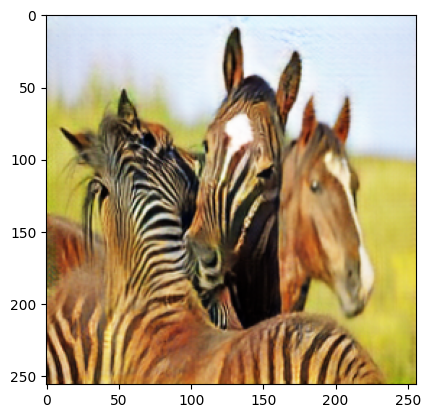

In [21]:
import matplotlib.pyplot as plt

img = plt.imread('./results/horse2zebra_pretrained/test_latest/images/n02381460_1010_fake.png')
plt.imshow(img)

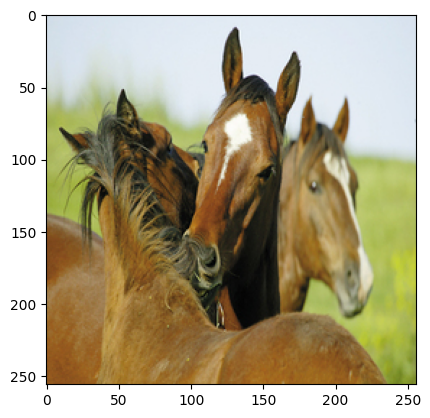

In [22]:
import matplotlib.pyplot as plt

img = plt.imread('./results/horse2zebra_pretrained/test_latest/images/n02381460_1010_real.png')
plt.imshow(img)

## Train

In [19]:
!python train.py \
    --dataroot ./datasets/horse2zebra \
    --name horse2zebra \
    --model cycle_gan \
    --display_id -1 \
    --n_epochs 1 --n_epochs_decay 1

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./datasets/horse2zebra        	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
 

### WESPE

- https://arxiv.org/pdf/1709.01118

In [ ]:
from networks.wespe.main import (
    load_checkpoints, train, test,
    load_test_data, WESPE, config,
    SummaryWriter, predict
)

import torch
import os

In [4]:
config.train_iters = 2
config.print_step = 1
config.dataset_dir = './datasets/dped_small/'

device = torch.device('cuda:0' if config.use_cuda else 'cpu')
models = WESPE(config).to(device)
if config.load_iter != 0:
    load_checkpoints(models)

models.train()
writer = SummaryWriter(logdir=os.path.join(config.tensorboard_dir, config.phone))
train(models, writer, device)

models.eval()
test(models, device)

Iteration: 1/2, gen_loss: 0.3180, dis_loss: 2.7201
gen_loss_content: 0.2621, gen_loss_color: 0.8246, gen_loss_texture: 4.1288, gen_loss_tv: 0.0031
dis_loss_color: 1.3330, dis_loss_texture: 1.3871
Iteration: 2/2, gen_loss: 0.2772, dis_loss: 2.7678
gen_loss_content: 0.1864, gen_loss_color: 14.1986, gen_loss_texture: 0.0000, gen_loss_tv: 0.0020
dis_loss_color: 0.9348, dis_loss_texture: 1.8329
PSNR : 6.9288, SSIM_skimage : 0.0000, SSIM_minstar : 0.9737, SSIM_msssim: 0.9979


In [4]:
config.train_iters = 2
config.print_step = 1
config.dataset_dir = './datasets/dped_small/'
config.resume_iter = 20000

device = torch.device('cuda:0' if config.use_cuda else 'cpu')

models = WESPE(config).to(device)
load_checkpoints(models)
models.eval()
test(models, device)

Loading the model checkpoints from iter 20000...


/home/gosha20777/miniconda3/envs/DosGAN/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


PSNR : 15.6135, SSIM_minstar : 0.9965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


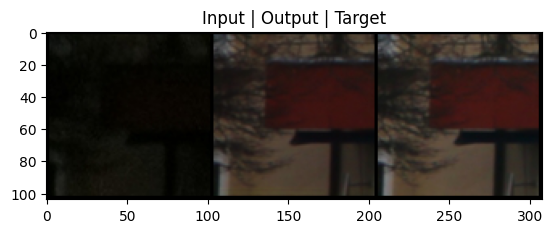

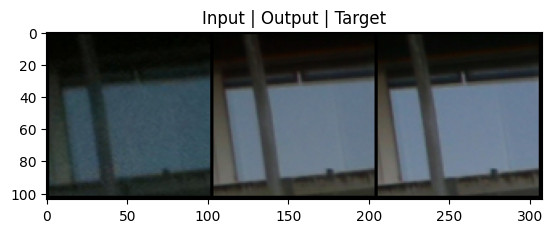

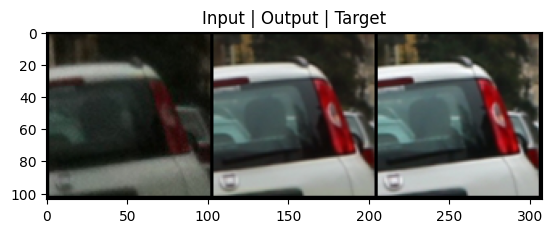

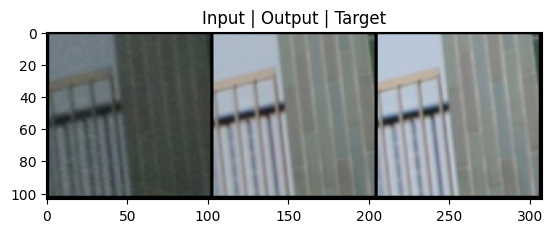

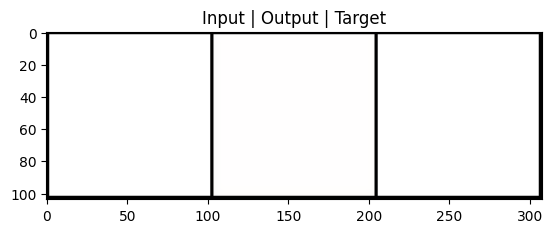

In [8]:
def predict_batch(model, device):
    test_path = config.dataset_dir + config.phone + '/test_data/patches/canon/'
    test_image_num = len([name for name in os.listdir(test_path)
                         if os.path.isfile(os.path.join(test_path, name))]) // config.batch_size * config.batch_size

    n = 0
    max_n = 5

    for start in range(0, test_image_num, config.batch_size):
        if n == max_n:
            break
        n += 1

        end = min(start + config.batch_size, test_image_num)
        test_phone, test_dslr = load_test_data(config.phone, config.dataset_dir, start, end,
                                               config.height * config.width * config.channels)
        prediction = predict(model, test_phone, test_dslr, device)

        plt_display(prediction, "Input | Output | Target")


predict_batch(models, device)

### UVCGAN v2 / Rawformer

- https://arxiv.org/pdf/2303.16280
- https://arxiv.org/pdf/2404.10700

In [89]:
import os
os.chdir('../../networks/uvcgan2/')

FileNotFoundError: [Errno 2] No such file or directory: '../../networks/uvcgan2/'

In [26]:
!bash ./scripts/download_dataset.sh selfie2anime

--2024-02-05 12:33:01--  https://www.dropbox.com/s/9lz6gwwwyyxpdnn/selfie2anime.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/9lz6gwwwyyxpdnn/selfie2anime.zip [following]
--2024-02-05 12:33:01--  https://www.dropbox.com/s/raw/9lz6gwwwyyxpdnn/selfie2anime.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0edb1fde37e36fc8f699d518c5.dl.dropboxusercontent.com/cd/0/inline/CMtBrGaO7yYyc5kKDPoCU5SxQISsCeGzzE388w77y98kGB8GGQvHrTFjKyeOo-RuUN-unmbTiXGMamR_sVSNKS7iVrW7TC98I5qy0CgtUsL4riryuycJPii9bkl5jddBnOvh7z6Y1vJ0MQHELfdaDFL1/file# [following]
--2024-02-05 12:33:02--  https://uc0edb1fde37e36fc8f699d518c5.dl.dropboxusercontent.com/cd/0/inline/CMtBrGaO7yYyc5kKDPoCU5SxQISsCeGzzE388w77y98kGB8GGQvHrTFjKyeOo-RuUN-unmbTiXGMamR_sVSNKS7

In [29]:
!bash ./scripts/download_model.sh anime2selfie_anime2selfie

--2024-02-05 12:47:51--  https://zenodo.org/record/7826901/files/anime2selfie_anime2selfie_only_gen.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/7826901/files/anime2selfie_anime2selfie_only_gen.zip [following]
--2024-02-05 12:47:52--  https://zenodo.org/records/7826901/files/anime2selfie_anime2selfie_only_gen.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 478016336 (456M) [application/octet-stream]
Saving to: ‘/home/gosha20777/Documents/Projects/uvcgan2/results//anime2selfie_anime2selfie_only_gen.zip’

/home/gosha20777/Do 100%[===================>] 455,87M  62,6MB/s    in 7,3s    

2024-02-05 12:47:59 (62,1 MB/s) - ‘/home/gosha20777/Documents/Projects/uvcgan2/results//anime2selfie_anime2selfie_only_gen.zip’ saved [478016336/47801

In [36]:
!python3 translate_images.py /home/gosha20777/Documents/Projects/uvcgan2/results/anime2selfie/anime2selfie --split test

/home/gosha20777/miniconda3/envs/DosGAN/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Load checkpoint at epoch None
Translating domain 0:   0%|                             | 0/100 [00:00<?, ?it/s]/home/gosha20777/miniconda3/envs/DosGAN/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Translating domain 1: 100%|███████████████████| 100/100 [00:04<00:00, 20.63it/s]


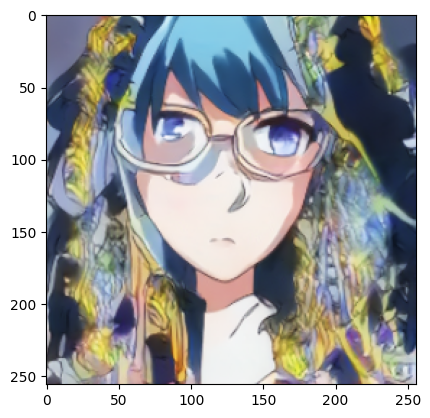

In [42]:
base_dir = "/home/gosha20777/Documents/Projects/uvcgan2/results/anime2selfie/anime2selfie/evals/final/images_eval-test"
fake = os.path.join(base_dir, "fake_b/sample_1.png")
real = os.path.join(base_dir, "real_a/sample_1.png")

import matplotlib.pyplot as plt

img = plt.imread(fake)
plt.imshow(img)

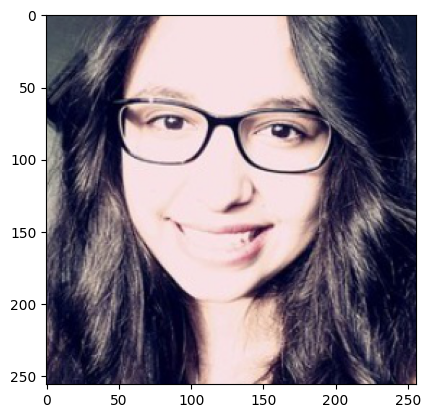

In [43]:
import matplotlib.pyplot as plt

img = plt.imread(real)
plt.imshow(img)

### Schroedinger Bridge and Optimal Transport

In [1]:
import os, sys

import torch
import numpy as np

from networks.LightSB.src.light_sb import LightSB
from networks.LightSB.src.distributions import LoaderSampler, TensorSampler
import deeplake
from tqdm import tqdm

import wandb
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sys.path.append("./networks/LightSB/ALAE/")

from networks.LightSB.ALAE.alae_ffhq_inference import load_model, encode, decode

In [2]:
DIM = 512
assert DIM > 1

INPUT_DATA = "ADULT" # MAN, WOMAN, ADULT, CHILDREN
TARGET_DATA = "CHILDREN" # MAN, WOMAN, ADULT, CHILDREN

OUTPUT_SEED = 0xBADBEEF
BATCH_SIZE = 128
EPSILON = 0.1
D_LR = 1e-3 # 1e-3 for eps 0.1
D_GRADIENT_MAX_NORM = float("inf")
N_POTENTIALS = 10
SAMPLING_BATCH_SIZE = 128
INIT_BY_SAMPLES = True
IS_DIAGONAL = True

MAX_STEPS = 10000
CONTINUE = -1

In [4]:
EXP_NAME = f'LightSB_ALAE_{INPUT_DATA}_TO_{TARGET_DATA}_EPSILON_{EPSILON}'
OUTPUT_PATH = 'checkpoints/{}'.format(EXP_NAME)

config = dict(
    DIM=DIM,
    D_LR=D_LR,
    BATCH_SIZE=BATCH_SIZE,
    EPSILON=EPSILON,
    D_GRADIENT_MAX_NORM=D_GRADIENT_MAX_NORM,
    N_POTENTIALS=N_POTENTIALS,
    INIT_BY_SAMPLES=INIT_BY_SAMPLES,
    IS_DIAGONAL=IS_DIAGONAL,
)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [6]:
import gdown
import os

urls = {
    "./data/age.npy": "https://drive.google.com/uc?id=1Vi6NzxCsS23GBNq48E-97Z9UuIuNaxPJ",
    "./data/gender.npy": "https://drive.google.com/uc?id=1SEdsmQGL3mOok1CPTBEfc_O1750fGRtf",
    "./data/latents.npy": "https://drive.google.com/uc?id=1ENhiTRsHtSjIjoRu1xYprcpNd8M9aVu8",
    "./data/test_images.npy": "https://drive.google.com/uc?id=1SjBWWlPjq-dxX4kxzW-Zn3iUR3po8Z0i",
}

for name, url in urls.items():
    gdown.download(url, os.path.join(f"{name}"), quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Vi6NzxCsS23GBNq48E-97Z9UuIuNaxPJ
To: /home/gosha20777/Documents/Projects/jmu/seminars/image-enhancement/data/age.npy
100%|██████████| 560k/560k [00:00<00:00, 37.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SEdsmQGL3mOok1CPTBEfc_O1750fGRtf
To: /home/gosha20777/Documents/Projects/jmu/seminars/image-enhancement/data/gender.npy
100%|██████████| 1.68M/1.68M [00:00<00:00, 36.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ENhiTRsHtSjIjoRu1xYprcpNd8M9aVu8
From (redirected): https://drive.google.com/uc?id=1ENhiTRsHtSjIjoRu1xYprcpNd8M9aVu8&confirm=t&uuid=c527d1a2-4e4d-427f-81ce-4d744b7ac3fc
To: /home/gosha20777/Documents/Projects/jmu/seminars/image-enhancement/data/latents.npy
100%|██████████| 143M/143M [00:01<00:00, 85.7MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1SjBWWlPjq-dxX4kxzW-Zn3iUR3po8Z0i
From (redirected): https://drive.google.com/uc?id=1SjBWWlPjq-dxX4kxzW-Zn3iUR3po8Z0i

In [7]:
# To download data use

train_size = 60000
test_size = 10000

latents = np.load("./data/latents.npy")
gender = np.load("./data/gender.npy")
age = np.load("./data/age.npy")
test_inp_images = np.load("./data/test_images.npy")

train_latents, test_latents = latents[:train_size], latents[train_size:]
train_gender, test_gender = gender[:train_size], gender[train_size:]
train_age, test_age = age[:train_size], age[train_size:]

if INPUT_DATA == "MAN":
    x_inds_train = np.arange(train_size)[(train_gender == "male").reshape(-1)]
    x_inds_test = np.arange(test_size)[(test_gender == "male").reshape(-1)]
elif INPUT_DATA == "WOMAN":
    x_inds_train = np.arange(train_size)[(train_gender == "female").reshape(-1)]
    x_inds_test = np.arange(test_size)[(test_gender == "female").reshape(-1)]
elif INPUT_DATA == "ADULT":
    x_inds_train = np.arange(train_size)[
        (train_age >= 18).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    x_inds_test = np.arange(test_size)[
        (test_age >= 18).reshape(-1)*(test_age != -1).reshape(-1)
    ]
elif INPUT_DATA == "CHILDREN":
    x_inds_train = np.arange(train_size)[
        (train_age < 18).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    x_inds_test = np.arange(test_size)[
        (test_age < 18).reshape(-1)*(test_age != -1).reshape(-1)
    ]
x_data_train = train_latents[x_inds_train]
x_data_test = test_latents[x_inds_test]

if TARGET_DATA == "MAN":
    y_inds_train = np.arange(train_size)[(train_gender == "male").reshape(-1)]
    y_inds_test = np.arange(test_size)[(test_gender == "male").reshape(-1)]
elif TARGET_DATA == "WOMAN":
    y_inds_train = np.arange(train_size)[(train_gender == "female").reshape(-1)]
    y_inds_test = np.arange(test_size)[(test_gender == "female").reshape(-1)]
elif TARGET_DATA == "ADULT":
    y_inds_train = np.arange(train_size)[
        (train_age >= 18).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    y_inds_test = np.arange(test_size)[
        (test_age >= 18).reshape(-1)*(test_age != -1).reshape(-1)
    ]
elif TARGET_DATA == "CHILDREN":
    y_inds_train = np.arange(train_size)[
        (train_age < 18).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    y_inds_test = np.arange(test_size)[
        (test_age < 18).reshape(-1)*(test_age != -1).reshape(-1)
    ]
y_data_train = train_latents[y_inds_train]
y_data_test = test_latents[y_inds_test]

X_train = torch.tensor(x_data_train)
Y_train = torch.tensor(y_data_train)

X_test = torch.tensor(x_data_test)
Y_test = torch.tensor(y_data_test)

X_sampler = TensorSampler(X_train, device="cpu")
Y_sampler = TensorSampler(Y_train, device="cpu")

In [8]:
torch.manual_seed(OUTPUT_SEED); np.random.seed(OUTPUT_SEED)

D = LightSB(dim=DIM, n_potentials=N_POTENTIALS, epsilon=EPSILON,
            sampling_batch_size=SAMPLING_BATCH_SIZE, S_diagonal_init=0.1,
            is_diagonal=IS_DIAGONAL).cpu()

if INIT_BY_SAMPLES:
    D.init_r_by_samples(Y_sampler.sample(N_POTENTIALS))
    
D_opt = torch.optim.Adam(D.parameters(), lr=D_LR)

In [10]:
model = load_model("./networks/LightSB/ALAE/configs/ffhq.yaml", training_artifacts_dir="./networks/LightSB/ALAE/training_artifacts/ffhq/")

In [11]:
wandb.init(name=EXP_NAME, config=config)

for step in tqdm(range(CONTINUE + 1, MAX_STEPS)):
    D_opt.zero_grad()
    
    X0, X1 = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)
    
    log_potential = D.get_log_potential(X1)
    log_C = D.get_log_C(X0)
    
    D_loss = (-log_potential + log_C).mean()
    D_loss.backward()
    D_gradient_norm = torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=D_GRADIENT_MAX_NORM)
    D_opt.step()
    
    wandb.log({f'D gradient norm' : D_gradient_norm.item()}, step=step)
    wandb.log({f'D_loss' : D_loss.item()}, step=step)
         
torch.save(D.state_dict(), os.path.join(OUTPUT_PATH, f'D.pt'))
torch.save(D_opt.state_dict(), os.path.join(OUTPUT_PATH, f'D_opt.pt'))

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gosha20777. Use `wandb login --relogin` to force relogin


100%|██████████| 10000/10000 [00:47<00:00, 209.64it/s]


In [12]:
torch.manual_seed(OUTPUT_SEED); np.random.seed(OUTPUT_SEED)

inds_to_map = np.random.choice(np.arange((x_inds_test < 300).sum()), size=10, replace=False)
number_of_samples = 3

mapped_all = []
latent_to_map = torch.tensor(test_latents[x_inds_test[inds_to_map]])

inp_images = test_inp_images[x_inds_test[inds_to_map]]

with torch.no_grad():
    for k in range(number_of_samples):
        mapped = D(latent_to_map.cpu())
        mapped_all.append(mapped)
    
mapped = torch.stack(mapped_all, dim=1)

decoded_all = []
with torch.no_grad():
    for k in range(number_of_samples):
        decoded_img = decode(model, mapped[:, k])
        decoded_img = ((decoded_img * 0.5 + 0.5) * 255).type(torch.long).clamp(0, 255).cpu().type(torch.uint8).permute(0, 2, 3, 1).numpy()
        decoded_all.append(decoded_img)
        
decoded_all = np.stack(decoded_all, axis=1)

In [ ]:
fig, axes = plt.subplots(10, number_of_samples+1, figsize=(number_of_samples+1, 10), dpi=200)

for i, ind in enumerate(range(10)):
    ax = axes[i]
    ax[0].imshow(inp_images[ind])
    for k in range(number_of_samples):
        ax[k+1].imshow(decoded_all[ind, k])
        
        ax[k+1].get_xaxis().set_visible(False)
        ax[k+1].set_yticks([])
        
    ax[0].get_xaxis().set_visible(False)
    ax[0].set_yticks([])

fig.tight_layout(pad=0.05)
fig.savefig('figures/alae_transfer.png')

In [21]:
import matplotlib.pyplot as plt

img = plt.imread('figures/alae_transfer.png')
plt.imshow(img)